# Lab 02: Feature Engineering - PCA, Rotation, and HOG Experiments

**Focus:** Design 4 (PCA Feature Vectors), Design 5 (Rotated Images), and Design 6 (HOG Features)

This notebook explores three advanced feature engineering techniques:
1. **Design 4:** Principal Component Analysis (PCA) for dimensionality reduction
2. **Design 5:** Image rotation for data augmentation and robustness
3. **Design 6:** Histogram of Oriented Gradients (HOG) for shape-based feature extraction

---


## 1. Introduction

In this notebook, we focus on three specific feature engineering approaches:

### Design 4: PCA Feature Vectors
**Principal Component Analysis (PCA)** is a dimensionality reduction technique that finds the directions of maximum variance in the data. By projecting images onto these principal components, we can:
- Reduce feature dimensionality (e.g., from 784 to 30-100 components)
- Remove noise and redundant information
- Speed up training while maintaining most of the information

### Design 5: Rotated Images
**Image Rotation** is a data augmentation technique that:
- Increases model robustness to orientation variations
- Augments the training dataset
- Helps the model generalize better to rotated digits in real-world scenarios

### Design 6: HOG (Histogram of Oriented Gradients)
**HOG** is a feature descriptor that captures local shape information by:
- Computing gradient magnitudes and orientations
- Creating histograms of gradient directions in local cells
- Normalizing across blocks to improve robustness
- Capturing edge and shape patterns that are discriminative for digit recognition

We will implement all three designs, visualize their effects, and compare their performance with baseline models.


In [18]:
import numpy as np
import matplotlib.pyplot as plt
import cv2  # OpenCV for image rotation
import os

np.random.seed(42)

def load_mnist_data(data_path='../data/raw/mnist.npz'):
    """Loads MNIST data from .npz file."""
    if not os.path.exists(data_path):
        print(f"Data file not found at {data_path}. Please run Notebook 1 first to download it.")
        return None, None, None, None

    with np.load(data_path) as f:
        x_train, y_train = f['x_train'], f['y_train']
        x_test, y_test = f['x_test'], f['y_test']

    # Pre-processing basic: Normalize to [0, 1]
    x_train = x_train.astype(np.float32) / 255.0
    x_test = x_test.astype(np.float32) / 255.0

    return x_train, y_train, x_test, y_test

def one_hot_encode(y, num_classes=10):
    m = y.shape[0]
    one_hot = np.zeros((m, num_classes))
    for i in range(m):
        one_hot[i, y[i]] = 1
    return one_hot

# Load Data (Keep as images 28x28 initially for Feature Extraction)
X_train_img, y_train, X_test_img, y_test = load_mnist_data()
print(f"Data Loaded: {X_train_img.shape} (Images)")
print(f"Training samples: {X_train_img.shape[0]}, Test samples: {X_test_img.shape[0]}")


Data Loaded: (60000, 28, 28) (Images)
Training samples: 60000, Test samples: 10000


In [19]:
class SoftmaxRegression:
    """
    Softmax Regression model implementation from scratch.
    """
    def __init__(self, n_features, n_classes, learning_rate=0.1):
        self.n_features = n_features
        self.n_classes = n_classes
        self.lr = learning_rate
        self.losses = []
        self.W = np.random.randn(n_features, n_classes) * 0.01
        self.b = np.zeros((1, n_classes))

    def softmax(self, z):
        z_stable = z - np.max(z, axis=1, keepdims=True)
        exp_z = np.exp(z_stable)
        return exp_z / np.sum(exp_z, axis=1, keepdims=True)

    def forward(self, X):
        z = np.dot(X, self.W) + self.b
        return self.softmax(z)

    def fit(self, X, y, epochs=50, batch_size=256, verbose=False):
        m = X.shape[0]
        self.losses = []
        for epoch in range(epochs):
            indices = np.arange(m)
            np.random.shuffle(indices)
            X_shuffled = X[indices]
            y_shuffled = y[indices]

            for i in range(0, m, batch_size):
                X_batch = X_shuffled[i:i+batch_size]
                y_batch = y_shuffled[i:i+batch_size]
                
                # Forward & Backward
                y_pred = self.forward(X_batch)
                dz = y_pred - y_batch
                dw = np.dot(X_batch.T, dz) / X_batch.shape[0]
                db = np.sum(dz, axis=0, keepdims=True) / X_batch.shape[0]
                
                self.W -= self.lr * dw
                self.b -= self.lr * db
                
            # Compute loss for monitoring
            if verbose and epoch % 10 == 0:
                full_pred = self.forward(X)
                loss = -np.sum(y * np.log(full_pred + 1e-9)) / m
                self.losses.append(loss)
                print(f"Epoch {epoch}: Loss {loss:.4f}")

    def predict(self, X):
        return np.argmax(self.forward(X), axis=1)


In [20]:
def compute_confusion_matrix(y_true, y_pred, n_classes=10):
    """Computes Confusion Matrix manually."""
    cm = np.zeros((n_classes, n_classes), dtype=int)
    for i in range(len(y_true)):
        cm[y_true[i], y_pred[i]] += 1
    return cm

def compute_metrics(y_true, y_pred, n_classes=10):
    """Computes Precision, Recall, and F1-score for each class and their macro-average."""
    cm = compute_confusion_matrix(y_true, y_pred, n_classes)
    
    precisions = []
    recalls = []
    f1_scores = []
    
    for c in range(n_classes):
        tp = cm[c, c]
        fp = np.sum(cm[:, c]) - tp
        fn = np.sum(cm[c, :]) - tp
        
        precision = tp / (tp + fp) if (tp + fp) > 0 else 0
        recall = tp / (tp + fn) if (tp + fn) > 0 else 0
        f1 = 2 * (precision * recall) / (precision + recall) if (precision + recall) > 0 else 0
        
        precisions.append(precision)
        recalls.append(recall)
        f1_scores.append(f1)
        
    metrics = {
        "confusion_matrix": cm,
        "precision_per_class": precisions,
        "recall_per_class": recalls,
        "f1_per_class": f1_scores,
        "macro_precision": np.mean(precisions),
        "macro_recall": np.mean(recalls),
        "macro_f1": np.mean(f1_scores),
        "accuracy": np.mean(y_true == y_pred)
    }
    return metrics

def plot_confusion_matrix(cm, title="Confusion Matrix"):
    """Visualizes the confusion matrix."""
    plt.figure(figsize=(8, 6))
    plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(10)
    plt.xticks(tick_marks, tick_marks)
    plt.yticks(tick_marks, tick_marks)
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            plt.text(j, i, format(cm[i, j], 'd'),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")
    plt.tight_layout()
    plt.show()


## 2. Design 4: PCA Feature Vectors

### 2.1. Theory

**Principal Component Analysis (PCA)** is a linear dimensionality reduction technique that:
1. Finds the directions (principal components) of maximum variance in the data
2. Projects the data onto these components
3. Retains most information with fewer dimensions

**Mathematical Formulation:**
- Given data matrix $X \in \mathbb{R}^{m \times n}$ (m samples, n features)
- Compute covariance matrix: $C = \frac{1}{m-1}X^T X$
- Find eigenvectors (principal components) and eigenvalues (variance explained)
- Project data: $X_{PCA} = X \cdot V_k^T$ where $V_k$ contains top k principal components

**Benefits:**
- Reduces dimensionality (e.g., 784 → 30-100 features)
- Removes noise and redundant information
- Speeds up training and inference
- Can improve generalization by focusing on important features


In [21]:
def apply_pca(X_train, X_test, n_components=50, explained_variance_threshold=0.95):
    """
    Applies PCA to reduce dimensionality.
    
    Args:
        X_train: Training data (N, 784) - flattened images
        X_test: Test data (M, 784) - flattened images
        n_components: Number of principal components to keep
        explained_variance_threshold: If provided, use enough components to explain this variance
    
    Returns:
        X_train_pca: Transformed training data (N, n_components)
        X_test_pca: Transformed test data (M, n_components)
        pca_components: Principal components (n_components, 784)
        pca_mean: Mean of training data (784,)
        explained_variance_ratio: Variance explained by each component
    """
    # Center the data using training mean
    mean = np.mean(X_train, axis=0)
    X_train_centered = X_train - mean
    X_test_centered = X_test - mean
    
    # Compute SVD: X = U * S * V^T
    # V^T contains principal components (rows)
    U, S, Vt = np.linalg.svd(X_train_centered, full_matrices=False)
    
    # Calculate explained variance ratio
    explained_variance = (S ** 2) / (X_train.shape[0] - 1)
    total_variance = np.sum(explained_variance)
    explained_variance_ratio = explained_variance / total_variance
    cumulative_variance = np.cumsum(explained_variance_ratio)
    
    # Determine number of components if using variance threshold
    if explained_variance_threshold is not None:
        n_components = np.argmax(cumulative_variance >= explained_variance_threshold) + 1
        n_components = min(n_components, len(S))
        print(f"Using {n_components} components to explain {cumulative_variance[n_components-1]*100:.2f}% variance")
    
    # Select top n_components
    components = Vt[:n_components]
    
    # Project data onto principal components
    X_train_pca = np.dot(X_train_centered, components.T)
    X_test_pca = np.dot(X_test_centered, components.T)
    
    return X_train_pca, X_test_pca, components, mean, explained_variance_ratio[:n_components]

# Flatten images for PCA
X_train_flat = X_train_img.reshape(X_train_img.shape[0], -1)
X_test_flat = X_test_img.reshape(X_test_img.shape[0], -1)

print("Applying PCA with different numbers of components...")
print("=" * 60)

# Try different numbers of components
n_components_list = [30, 50, 100, 200]
pca_results = {}

for n_comp in n_components_list:
    X_train_pca, X_test_pca, components, mean, var_ratio = apply_pca(
        X_train_flat, X_test_flat, n_components=n_comp, explained_variance_threshold=None
    )
    pca_results[n_comp] = {
        'X_train': X_train_pca,
        'X_test': X_test_pca,
        'components': components,
        'mean': mean,
        'variance_ratio': var_ratio,
        'cumulative_variance': np.sum(var_ratio)
    }
    print(f"n_components={n_comp}: Shape={X_train_pca.shape}, "
          f"Cumulative Variance={np.sum(var_ratio)*100:.2f}%")


Applying PCA with different numbers of components...
n_components=30: Shape=(60000, 30), Cumulative Variance=73.05%
n_components=50: Shape=(60000, 50), Cumulative Variance=82.46%
n_components=100: Shape=(60000, 100), Cumulative Variance=91.46%
n_components=200: Shape=(60000, 200), Cumulative Variance=96.64%


### 2.2. Visualization: PCA Components and Reconstruction


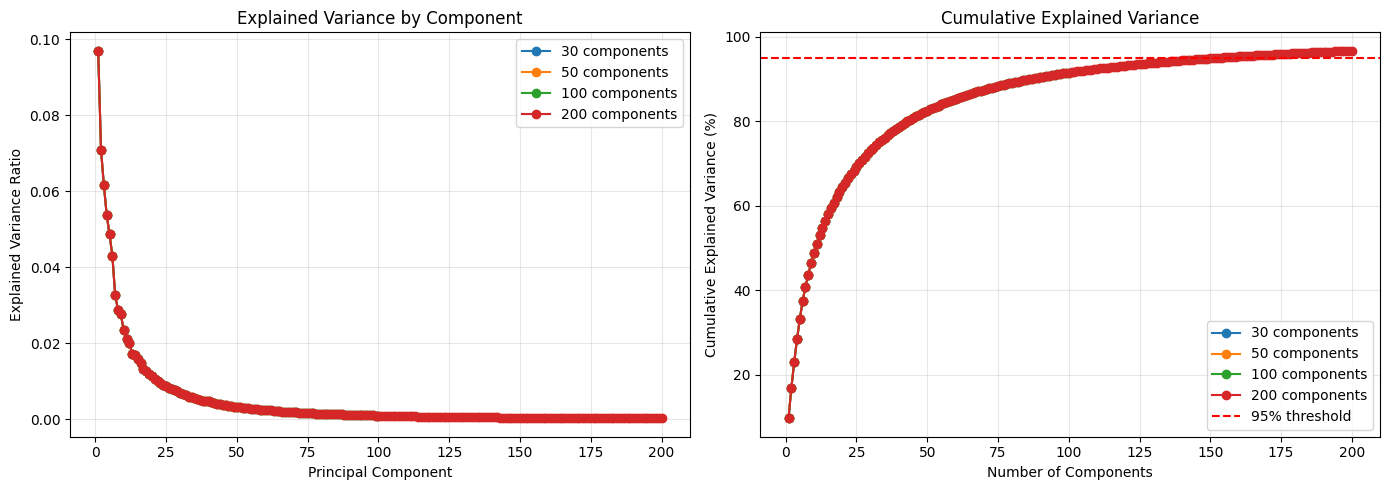

In [22]:
# Visualize explained variance
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Plot 1: Explained variance ratio for different n_components
for n_comp in n_components_list:
    var_ratio = pca_results[n_comp]['variance_ratio']
    axes[0].plot(range(1, len(var_ratio) + 1), var_ratio, marker='o', label=f'{n_comp} components')
axes[0].set_xlabel('Principal Component')
axes[0].set_ylabel('Explained Variance Ratio')
axes[0].set_title('Explained Variance by Component')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# Plot 2: Cumulative variance
for n_comp in n_components_list:
    var_ratio = pca_results[n_comp]['variance_ratio']
    cumulative = np.cumsum(var_ratio)
    axes[1].plot(range(1, len(cumulative) + 1), cumulative * 100, marker='o', label=f'{n_comp} components')
axes[1].axhline(y=95, color='r', linestyle='--', label='95% threshold')
axes[1].set_xlabel('Number of Components')
axes[1].set_ylabel('Cumulative Explained Variance (%)')
axes[1].set_title('Cumulative Explained Variance')
axes[1].legend()
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()


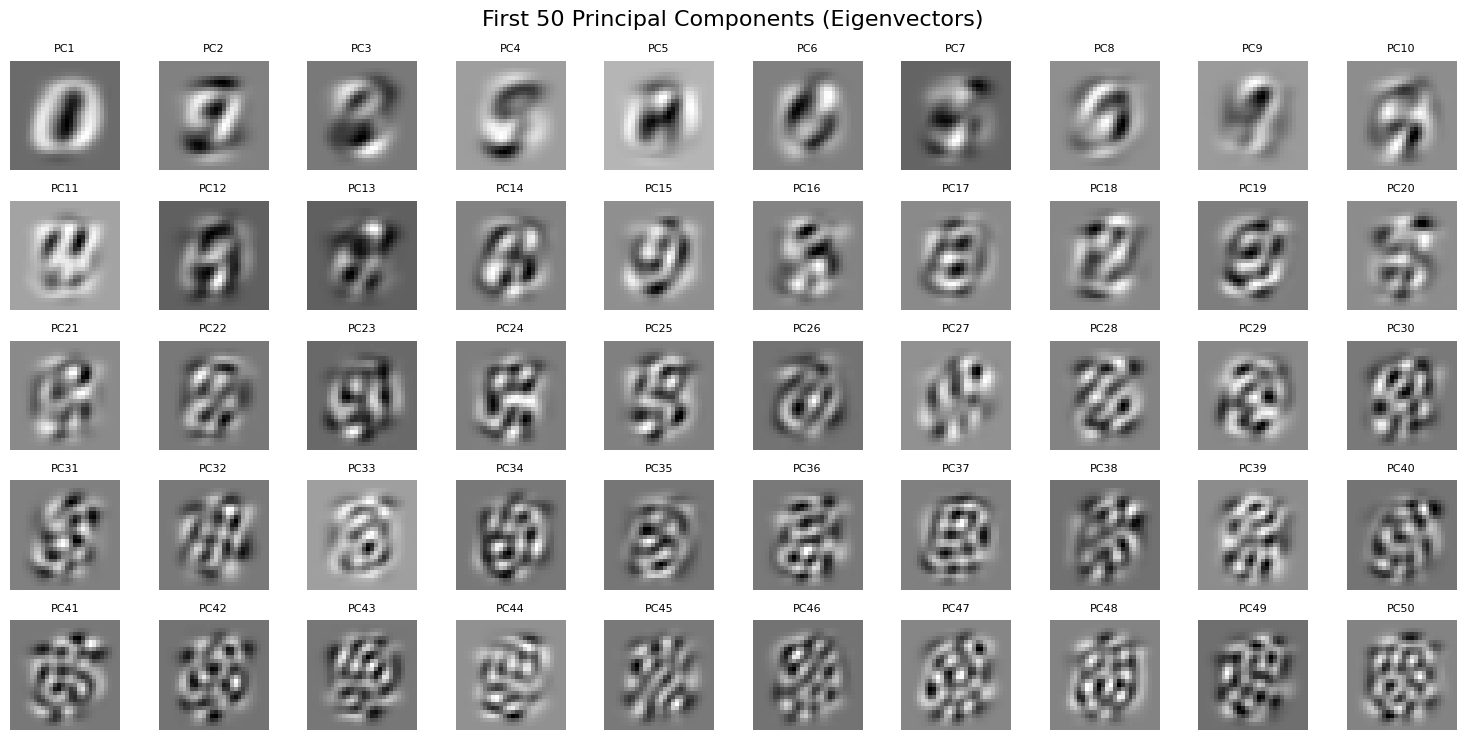

In [23]:
# Visualize principal components (eigenvectors) as images
n_comp_vis = 50
components = pca_results[n_comp_vis]['components']

fig, axes = plt.subplots(5, 10, figsize=(15, 7.5))
fig.suptitle(f'First 50 Principal Components (Eigenvectors)', fontsize=16)

for i in range(50):
    row, col = i // 10, i % 10
    axes[row, col].imshow(components[i].reshape(28, 28), cmap='gray')
    axes[row, col].set_title(f'PC{i+1}', fontsize=8)
    axes[row, col].axis('off')

plt.tight_layout()
plt.show()


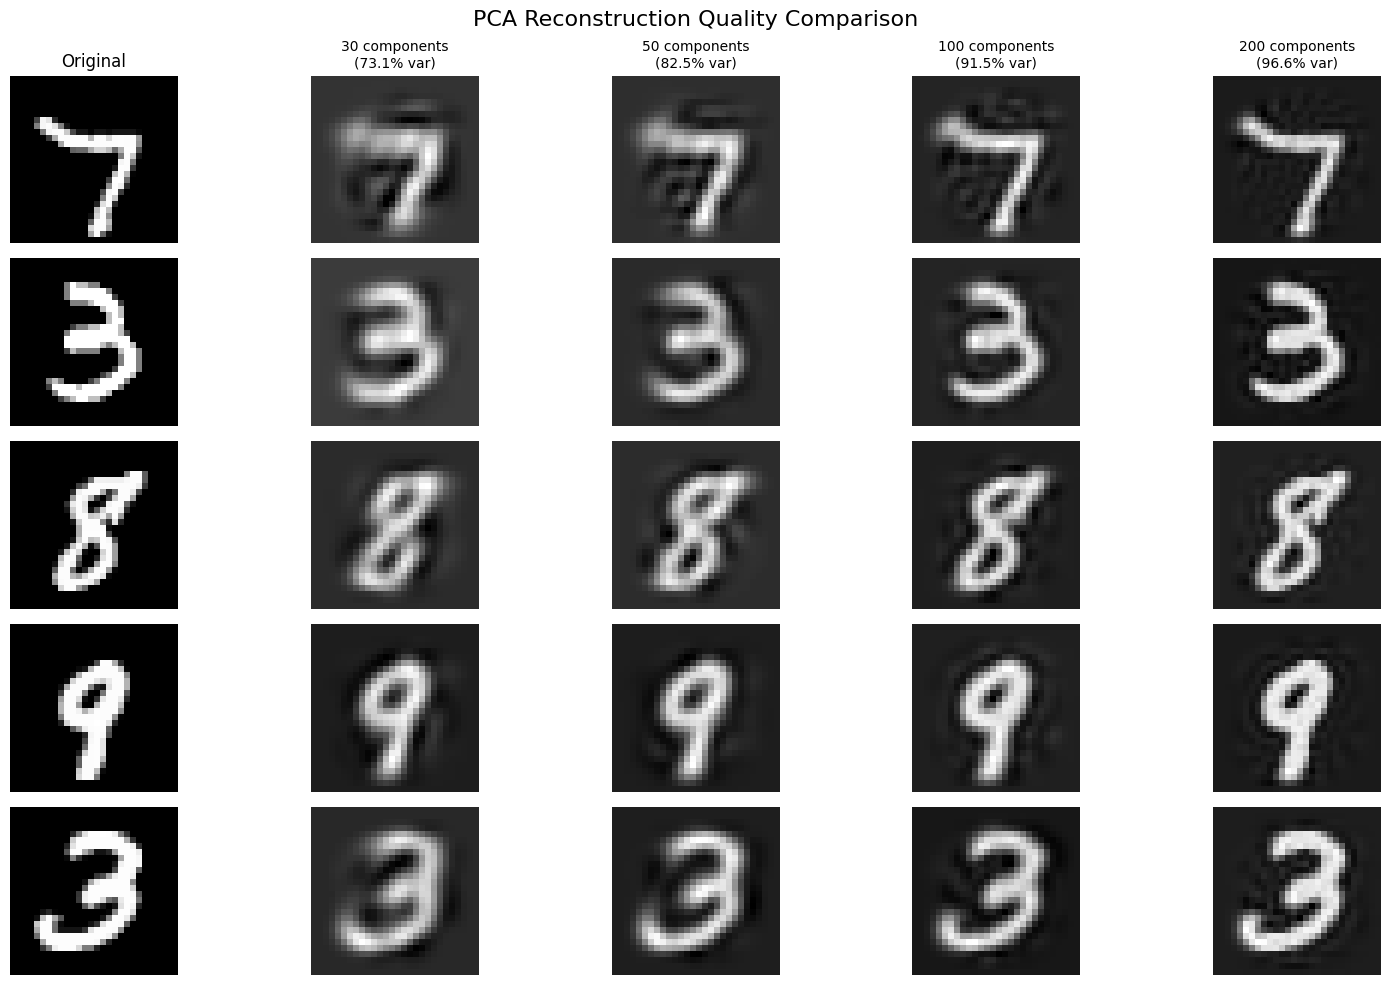

In [24]:
# Visualize PCA reconstruction quality
def reconstruct_from_pca(X_pca, components, mean):
    """Reconstruct image from PCA features."""
    return np.dot(X_pca, components) + mean

# Select a few sample images
sample_indices = np.random.choice(X_train_img.shape[0], 5, replace=False)

fig, axes = plt.subplots(5, len(n_components_list) + 1, figsize=(16, 10))
fig.suptitle('PCA Reconstruction Quality Comparison', fontsize=16)

for row, idx in enumerate(sample_indices):
    original = X_train_img[idx]
    
    # Original image
    axes[row, 0].imshow(original, cmap='gray')
    if row == 0:
        axes[row, 0].set_title('Original', fontsize=12)
    axes[row, 0].axis('off')
    
    # Reconstructions with different n_components
    for col, n_comp in enumerate(n_components_list, 1):
        X_pca = pca_results[n_comp]['X_train'][idx]
        components = pca_results[n_comp]['components']
        mean = pca_results[n_comp]['mean']
        reconstructed = reconstruct_from_pca(X_pca.reshape(1, -1), components, mean).reshape(28, 28)
        
        axes[row, col].imshow(reconstructed, cmap='gray')
        if row == 0:
            axes[row, col].set_title(f'{n_comp} components\n({pca_results[n_comp]["cumulative_variance"]*100:.1f}% var)', 
                                    fontsize=10)
        axes[row, col].axis('off')

plt.tight_layout()
plt.show()


## 3. Design 5: Rotated Images

### 3.1. Theory

**Image Rotation** is a data augmentation technique that:
- Rotates images by a specified angle (e.g., ±15°, ±30°)
- Increases dataset diversity
- Improves model robustness to orientation variations
- Helps generalize to real-world scenarios where digits may be rotated

**Implementation:**
- Use OpenCV's `cv2.getRotationMatrix2D()` and `cv2.warpAffine()`
- Rotate around image center
- Handle edge cases (border pixels) appropriately

**Expected Benefits:**
- Better generalization to rotated test samples
- More robust feature representation
- Potentially higher accuracy on rotated digits


In [25]:
def rotate_image(img, angle, center=None):
    """
    Rotate image by specified angle.
    
    Args:
        img: Input image (28, 28) with values in [0, 1]
        angle: Rotation angle in degrees (positive = counterclockwise)
        center: Rotation center (default: image center)
    
    Returns:
        Rotated image (28, 28)
    """
    h, w = img.shape
    if center is None:
        center = (w / 2.0, h / 2.0)
    
    # Get rotation matrix
    M = cv2.getRotationMatrix2D(center, angle, 1.0)
    
    # Apply rotation
    # Use BORDER_REPLICATE to avoid black corners, or BORDER_CONSTANT with value=0
    rotated = cv2.warpAffine(img, M, (w, h), 
                             flags=cv2.INTER_LINEAR, 
                             borderMode=cv2.BORDER_REPLICATE)
    
    return rotated

def extract_rotated_features(X_img, angle=15):
    """
    Extract features from rotated images.
    
    Args:
        X_img: Input images (N, 28, 28)
        angle: Rotation angle in degrees
    
    Returns:
        Flattened rotated images (N, 784)
    """
    N = X_img.shape[0]
    features = []
    
    for img in X_img:
        rotated = rotate_image(img, angle)
        features.append(rotated.flatten())
    
    return np.array(features)

# Apply rotation with different angles
rotation_angles = [15, 30, -15, -30]
rotation_results = {}

print("Applying rotation transformations...")
print("=" * 60)

for angle in rotation_angles:
    X_train_rot = extract_rotated_features(X_train_img, angle=angle)
    X_test_rot = extract_rotated_features(X_test_img, angle=angle)
    rotation_results[angle] = {
        'X_train': X_train_rot,
        'X_test': X_test_rot
    }
    print(f"Rotation angle={angle}°: Shape={X_train_rot.shape}")

# Also create a version with random rotations (data augmentation)
def extract_random_rotated_features(X_img, max_angle=15):
    """Extract features with random rotation for each image."""
    N = X_img.shape[0]
    features = []
    angles = np.random.uniform(-max_angle, max_angle, N)
    
    for i, img in enumerate(X_img):
        rotated = rotate_image(img, angles[i])
        features.append(rotated.flatten())
    
    return np.array(features)

print("\nCreating random rotation dataset (max ±15°)...")
X_train_rot_random = extract_random_rotated_features(X_train_img, max_angle=15)
X_test_rot_random = extract_random_rotated_features(X_test_img, max_angle=15)
rotation_results['random_15'] = {
    'X_train': X_train_rot_random,
    'X_test': X_test_rot_random
}
print(f"Random rotation (±15°): Shape={X_train_rot_random.shape}")


Applying rotation transformations...
Rotation angle=15°: Shape=(60000, 784)
Rotation angle=30°: Shape=(60000, 784)
Rotation angle=-15°: Shape=(60000, 784)
Rotation angle=-30°: Shape=(60000, 784)

Creating random rotation dataset (max ±15°)...
Random rotation (±15°): Shape=(60000, 784)


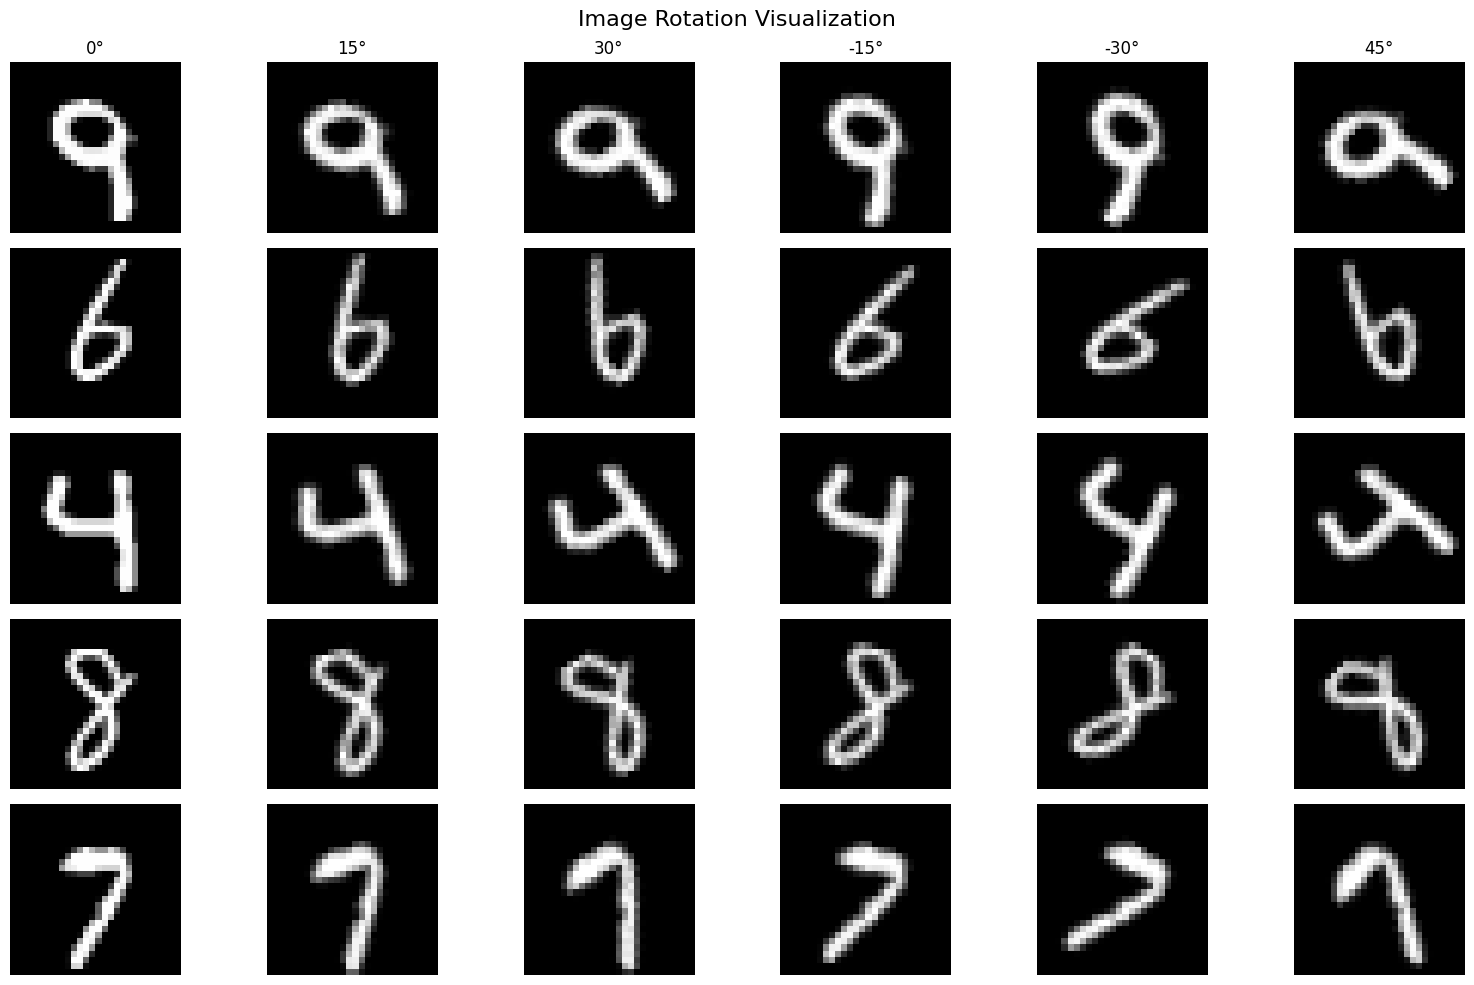

In [26]:
# Visualize rotation effects on sample images
sample_indices = np.random.choice(X_train_img.shape[0], 5, replace=False)
angles_to_show = [0, 15, 30, -15, -30, 45]

fig, axes = plt.subplots(len(sample_indices), len(angles_to_show), figsize=(16, 10))
fig.suptitle('Image Rotation Visualization', fontsize=16)

for row, idx in enumerate(sample_indices):
    original = X_train_img[idx]
    label = y_train[idx]
    
    for col, angle in enumerate(angles_to_show):
        if angle == 0:
            img = original
        else:
            img = rotate_image(original, angle)
        
        axes[row, col].imshow(img, cmap='gray')
        if row == 0:
            axes[row, col].set_title(f'{angle}°', fontsize=12)
        if col == 0:
            axes[row, col].set_ylabel(f'Label: {label}', fontsize=10)
        axes[row, col].axis('off')

plt.tight_layout()
plt.show()


## 4. Design 6: HOG (Histogram of Oriented Gradients)

### 4.1. Theory

**Histogram of Oriented Gradients (HOG)** is a feature descriptor that captures local shape and edge information:

**Mechanism:**
1. **Compute Gradients:** Calculate gradient magnitude and orientation for each pixel
2. **Divide into Cells:** Split image into small spatial regions (cells), e.g., 7×7 pixels
3. **Create Histograms:** For each cell, create a histogram of gradient orientations (typically 9 bins: 0°, 20°, 40°, ..., 160°)
4. **Block Normalization:** Group cells into blocks (e.g., 2×2 cells) and normalize histograms to reduce sensitivity to lighting variations
5. **Concatenate:** Flatten all normalized histograms into a single feature vector

**For MNIST (28×28 images):**
- `pixels_per_cell = (7, 7)` → 4×4 = 16 cells
- `cells_per_block = (2, 2)` → 3×3 = 9 overlapping blocks
- `orientations = 9` → 9 orientation bins
- Feature dimension: 9 blocks × 4 cells/block × 9 bins = **324 features**

**Benefits:**
- Captures shape and edge information effectively
- Robust to lighting variations (due to block normalization)
- Focuses on local patterns rather than absolute pixel values
- Good for object recognition tasks


In [27]:
def compute_hog_features(img, pixels_per_cell=(7, 7), cells_per_block=(2, 2), orientations=9):
    """
    Compute HOG features for a single image.
    
    Args:
        img: Input image (H, W) with values in [0, 1]
        pixels_per_cell: Size of each cell in pixels (height, width)
        cells_per_block: Number of cells per block (height, width)
        orientations: Number of orientation bins
    
    Returns:
        hog_features: Flattened HOG feature vector
    """
    h, w = img.shape
    
    # Convert to uint8 for gradient computation (0-255 range)
    img_uint8 = (img * 255).astype(np.uint8)
    
    # Compute gradients using Sobel operators
    gx = cv2.Sobel(img_uint8, cv2.CV_64F, 1, 0, ksize=3)
    gy = cv2.Sobel(img_uint8, cv2.CV_64F, 0, 1, ksize=3)
    
    # Compute gradient magnitude and orientation
    magnitude = np.sqrt(gx**2 + gy**2)
    orientation = np.arctan2(gy, gx)  # Returns values in [-π, π]
    orientation = np.degrees(orientation)  # Convert to degrees [-180, 180]
    orientation = (orientation + 180) % 180  # Convert to [0, 180]
    
    # Cell dimensions
    cell_h, cell_w = pixels_per_cell
    n_cells_y = h // cell_h
    n_cells_x = w // cell_w
    
    # Create cell histograms
    cell_histograms = np.zeros((n_cells_y, n_cells_x, orientations))
    
    # Bin width for orientations
    bin_width = 180.0 / orientations
    
    for cy in range(n_cells_y):
        for cx in range(n_cells_x):
            # Get cell region
            y_start = cy * cell_h
            y_end = y_start + cell_h
            x_start = cx * cell_w
            x_end = x_start + cell_w
            
            cell_mag = magnitude[y_start:y_end, x_start:x_end]
            cell_ori = orientation[y_start:y_end, x_start:x_end]
            
            # Create histogram for this cell
            for i in range(cell_h):
                for j in range(cell_w):
                    mag = cell_mag[i, j]
                    ori = cell_ori[i, j]
                    
                    # Determine which bins this orientation contributes to
                    bin_idx = int(ori / bin_width)
                    bin_idx = min(bin_idx, orientations - 1)  # Handle edge case
                    
                    # Bilinear interpolation for smoother histograms
                    bin_center = (bin_idx + 0.5) * bin_width
                    if ori < bin_center:
                        # Contribute to previous bin
                        prev_bin = (bin_idx - 1) % orientations
                        weight_prev = (bin_center - ori) / bin_width
                        cell_histograms[cy, cx, prev_bin] += mag * weight_prev
                        cell_histograms[cy, cx, bin_idx] += mag * (1 - weight_prev)
                    else:
                        # Contribute to next bin
                        next_bin = (bin_idx + 1) % orientations
                        weight_next = (ori - bin_center) / bin_width
                        cell_histograms[cy, cx, bin_idx] += mag * (1 - weight_next)
                        cell_histograms[cy, cx, next_bin] += mag * weight_next
    
    # Block normalization
    block_h, block_w = cells_per_block
    n_blocks_y = n_cells_y - block_h + 1
    n_blocks_x = n_cells_x - block_w + 1
    
    hog_features = []
    
    for by in range(n_blocks_y):
        for bx in range(n_blocks_x):
            # Get block region
            block_hist = cell_histograms[by:by+block_h, bx:bx+block_w, :]
            
            # Flatten block histogram
            block_vector = block_hist.flatten()
            
            # L2 normalization
            norm = np.linalg.norm(block_vector)
            if norm > 0:
                block_vector = block_vector / norm
            
            hog_features.extend(block_vector)
    
    return np.array(hog_features)

def extract_hog_features(X_img, pixels_per_cell=(7, 7), cells_per_block=(2, 2), orientations=9):
    """
    Extract HOG features for a batch of images.
    
    Args:
        X_img: Input images (N, H, W)
        pixels_per_cell: Size of each cell
        cells_per_block: Number of cells per block
        orientations: Number of orientation bins
    
    Returns:
        HOG features (N, feature_dim)
    """
    features = []
    for img in X_img:
        hog_feat = compute_hog_features(img, pixels_per_cell, cells_per_block, orientations)
        features.append(hog_feat)
    return np.array(features)

# Apply HOG feature extraction
print("Extracting HOG features...")
print("=" * 60)

X_train_hog = extract_hog_features(X_train_img, pixels_per_cell=(7, 7), cells_per_block=(2, 2), orientations=9)
X_test_hog = extract_hog_features(X_test_img, pixels_per_cell=(7, 7), cells_per_block=(2, 2), orientations=9)

print(f"HOG Feature Shape: {X_train_hog.shape}")
print(f"Feature dimension: {X_train_hog.shape[1]} features per image")


Extracting HOG features...
HOG Feature Shape: (60000, 324)
Feature dimension: 324 features per image


### 4.2. Visualization: HOG Features



HOG Visualization for Label: 5


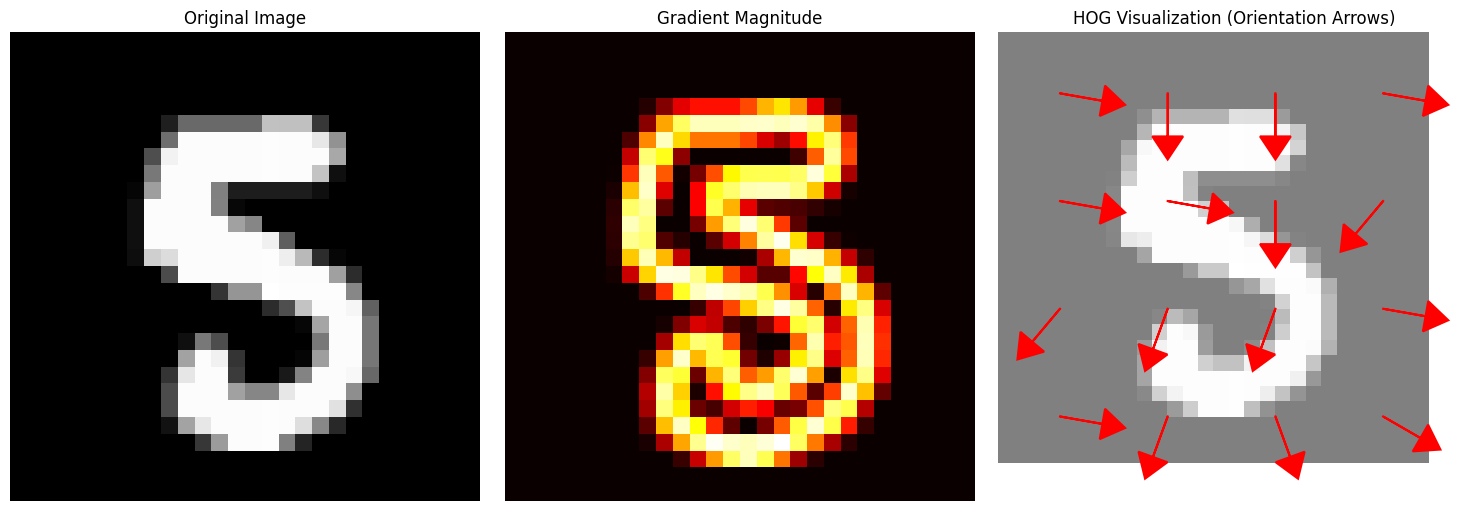


HOG Visualization for Label: 2


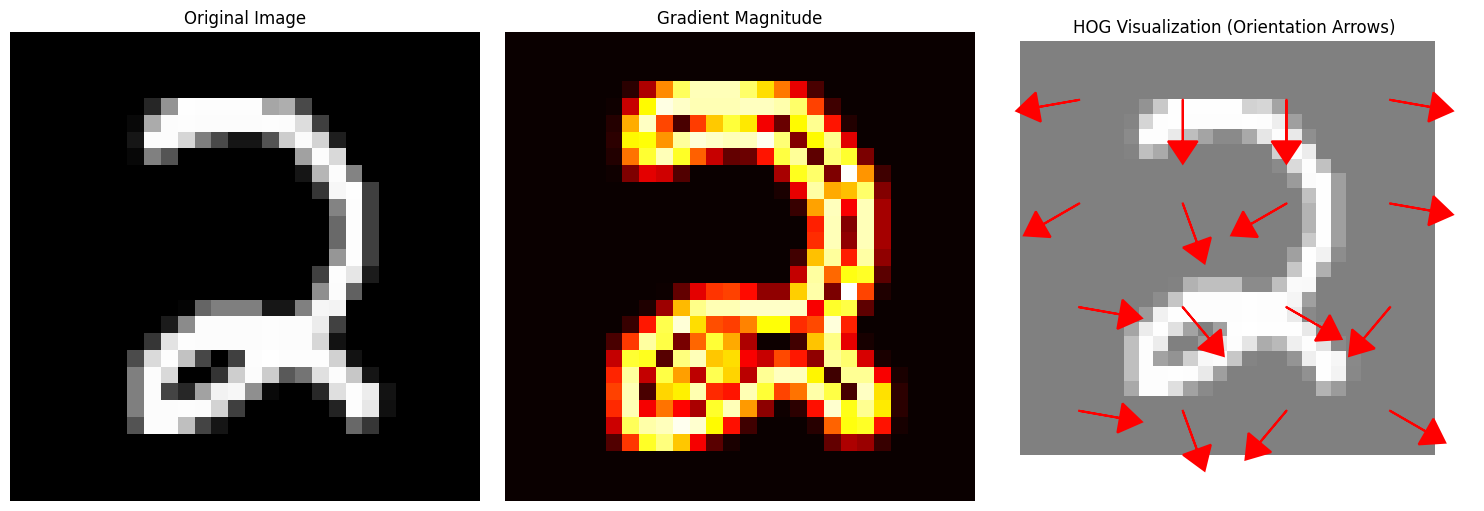


HOG Visualization for Label: 7


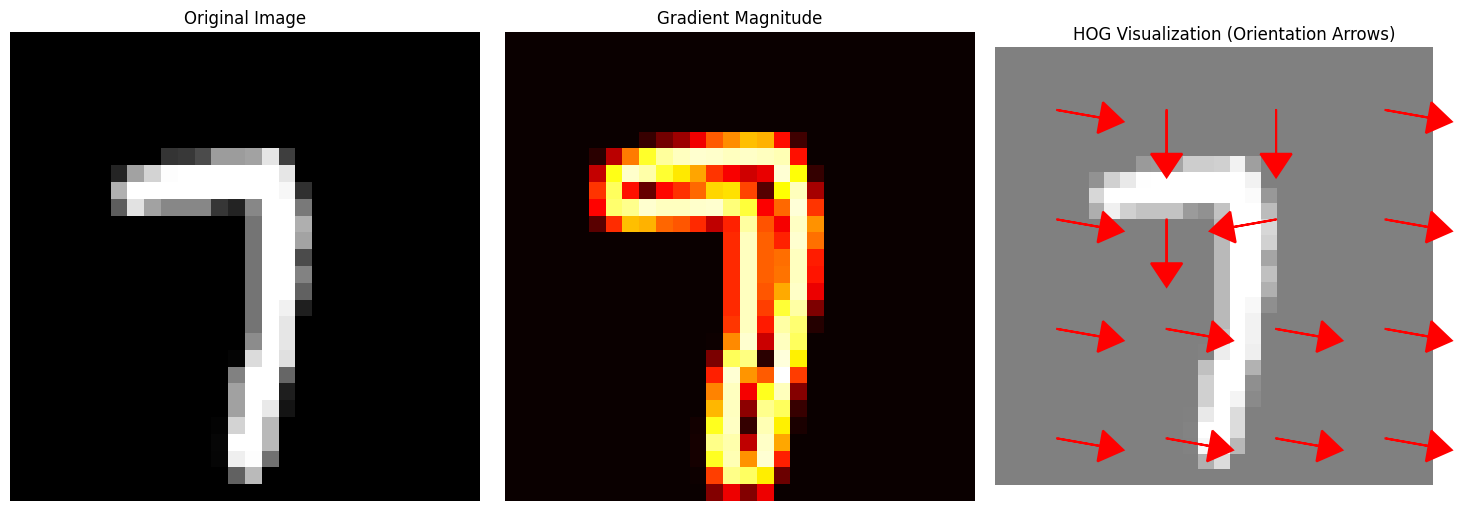


HOG Visualization for Label: 7


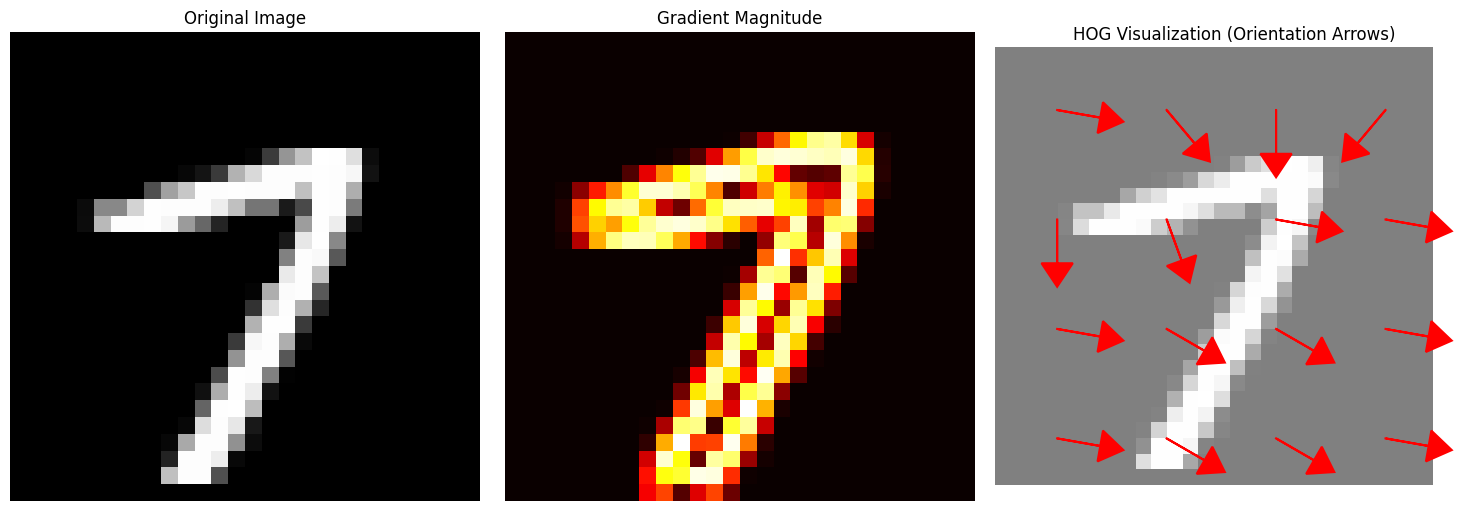


HOG Visualization for Label: 5


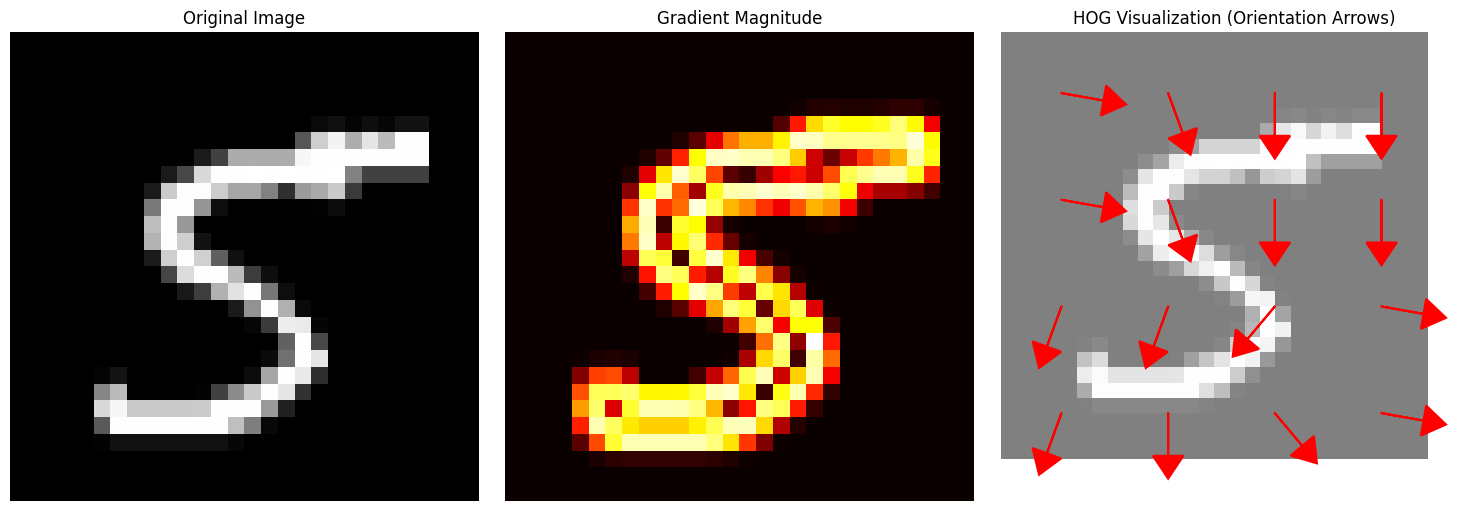

In [28]:
def visualize_hog(img, pixels_per_cell=(7, 7), cells_per_block=(2, 2), orientations=9):
    """
    Visualize HOG features by showing gradient orientations.
    """
    h, w = img.shape
    
    # Convert to uint8
    img_uint8 = (img * 255).astype(np.uint8)
    
    # Compute gradients
    gx = cv2.Sobel(img_uint8, cv2.CV_64F, 1, 0, ksize=3)
    gy = cv2.Sobel(img_uint8, cv2.CV_64F, 0, 1, ksize=3)
    
    magnitude = np.sqrt(gx**2 + gy**2)
    orientation = np.arctan2(gy, gx)
    orientation = np.degrees(orientation)
    orientation = (orientation + 180) % 180
    
    # Create visualization
    fig, axes = plt.subplots(1, 3, figsize=(15, 5))
    
    # Original image
    axes[0].imshow(img, cmap='gray')
    axes[0].set_title('Original Image', fontsize=12)
    axes[0].axis('off')
    
    # Gradient magnitude
    axes[1].imshow(magnitude, cmap='hot')
    axes[1].set_title('Gradient Magnitude', fontsize=12)
    axes[1].axis('off')
    
    # HOG visualization with orientation arrows
    cell_h, cell_w = pixels_per_cell
    n_cells_y = h // cell_h
    n_cells_x = w // cell_w
    
    axes[2].imshow(img, cmap='gray', alpha=0.5)
    
    # Draw orientation arrows for each cell
    for cy in range(n_cells_y):
        for cx in range(n_cells_x):
            y_center = (cy + 0.5) * cell_h
            x_center = (cx + 0.5) * cell_w
            
            # Get dominant orientation in this cell
            y_start = cy * cell_h
            y_end = y_start + cell_h
            x_start = cx * cell_w
            x_end = x_start + cell_w
            
            cell_mag = magnitude[y_start:y_end, x_start:x_end]
            cell_ori = orientation[y_start:y_end, x_start:x_end]
            
            # Find dominant orientation
            bin_width = 180.0 / orientations
            hist = np.zeros(orientations)
            for i in range(cell_h):
                for j in range(cell_w):
                    ori = cell_ori[i, j]
                    bin_idx = int(ori / bin_width)
                    bin_idx = min(bin_idx, orientations - 1)
                    hist[bin_idx] += cell_mag[i, j]
            
            dominant_bin = np.argmax(hist)
            dominant_angle = (dominant_bin + 0.5) * bin_width
            dominant_angle_rad = np.radians(dominant_angle)
            
            # Draw arrow
            arrow_length = min(cell_h, cell_w) * 0.4
            dx = arrow_length * np.cos(dominant_angle_rad)
            dy = arrow_length * np.sin(dominant_angle_rad)
            
            axes[2].arrow(x_center, y_center, dx, dy, head_width=2, head_length=1.5, 
                         fc='red', ec='red', linewidth=1.5)
    
    axes[2].set_title('HOG Visualization (Orientation Arrows)', fontsize=12)
    axes[2].axis('off')
    
    plt.tight_layout()
    plt.show()

# Visualize HOG for sample images
sample_indices = np.random.choice(X_train_img.shape[0], 5, replace=False)

for idx in sample_indices:
    sample_img = X_train_img[idx]
    label = y_train[idx]
    print(f"\nHOG Visualization for Label: {label}")
    visualize_hog(sample_img)


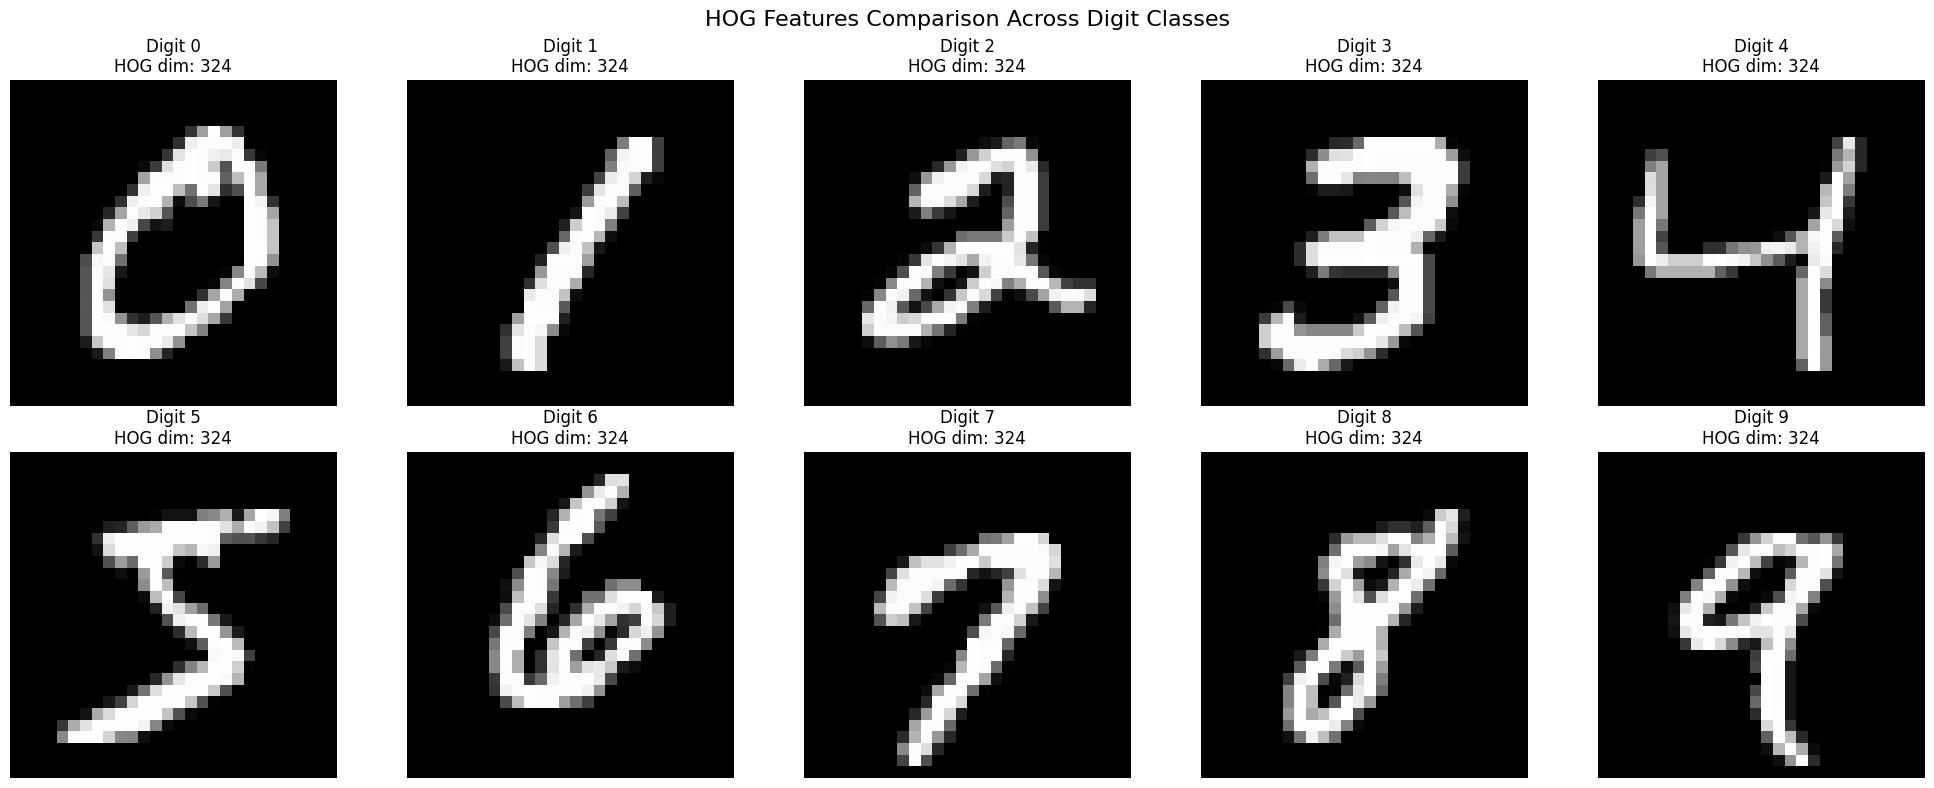

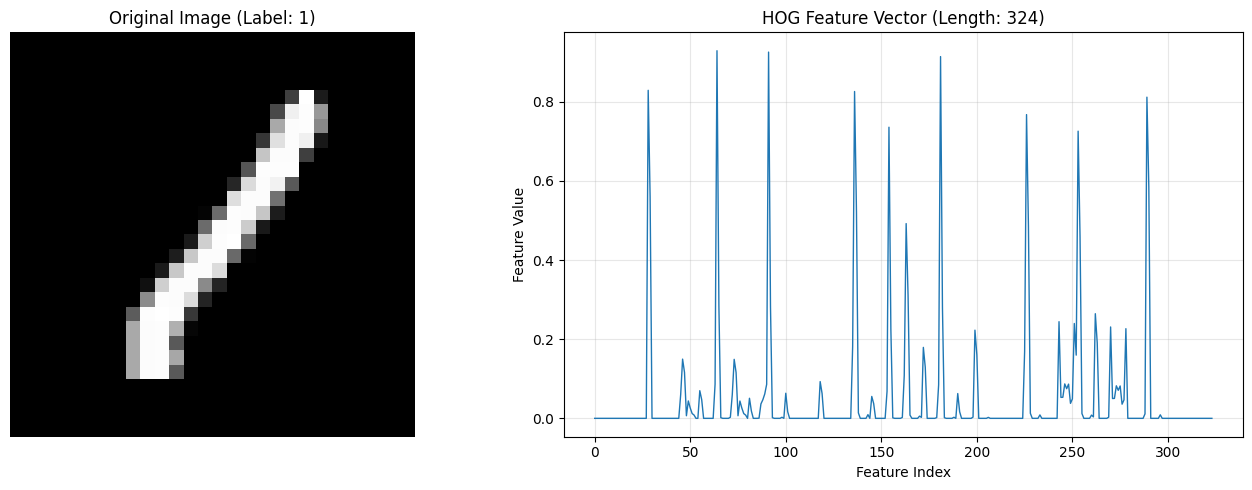

In [29]:
# Compare HOG features across different digits
fig, axes = plt.subplots(2, 5, figsize=(20, 8))
fig.suptitle('HOG Features Comparison Across Digit Classes', fontsize=16)

for digit in range(10):
    # Find first occurrence of each digit
    digit_idx = np.where(y_train == digit)[0][0]
    original = X_train_img[digit_idx]
    hog_feat = X_train_hog[digit_idx]
    
    row = digit // 5
    col = digit % 5
    
    # Show original image
    axes[row, col].imshow(original, cmap='gray')
    axes[row, col].set_title(f'Digit {digit}\nHOG dim: {len(hog_feat)}', fontsize=12)
    axes[row, col].axis('off')

plt.tight_layout()
plt.show()

# Show HOG feature vector distribution for a sample
sample_idx = np.random.choice(X_train_img.shape[0], 1)[0]
sample_hog = X_train_hog[sample_idx]

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

axes[0].imshow(X_train_img[sample_idx], cmap='gray')
axes[0].set_title(f'Original Image (Label: {y_train[sample_idx]})', fontsize=12)
axes[0].axis('off')

axes[1].plot(sample_hog, linewidth=1)
axes[1].set_title(f'HOG Feature Vector (Length: {len(sample_hog)})', fontsize=12)
axes[1].set_xlabel('Feature Index')
axes[1].set_ylabel('Feature Value')
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()


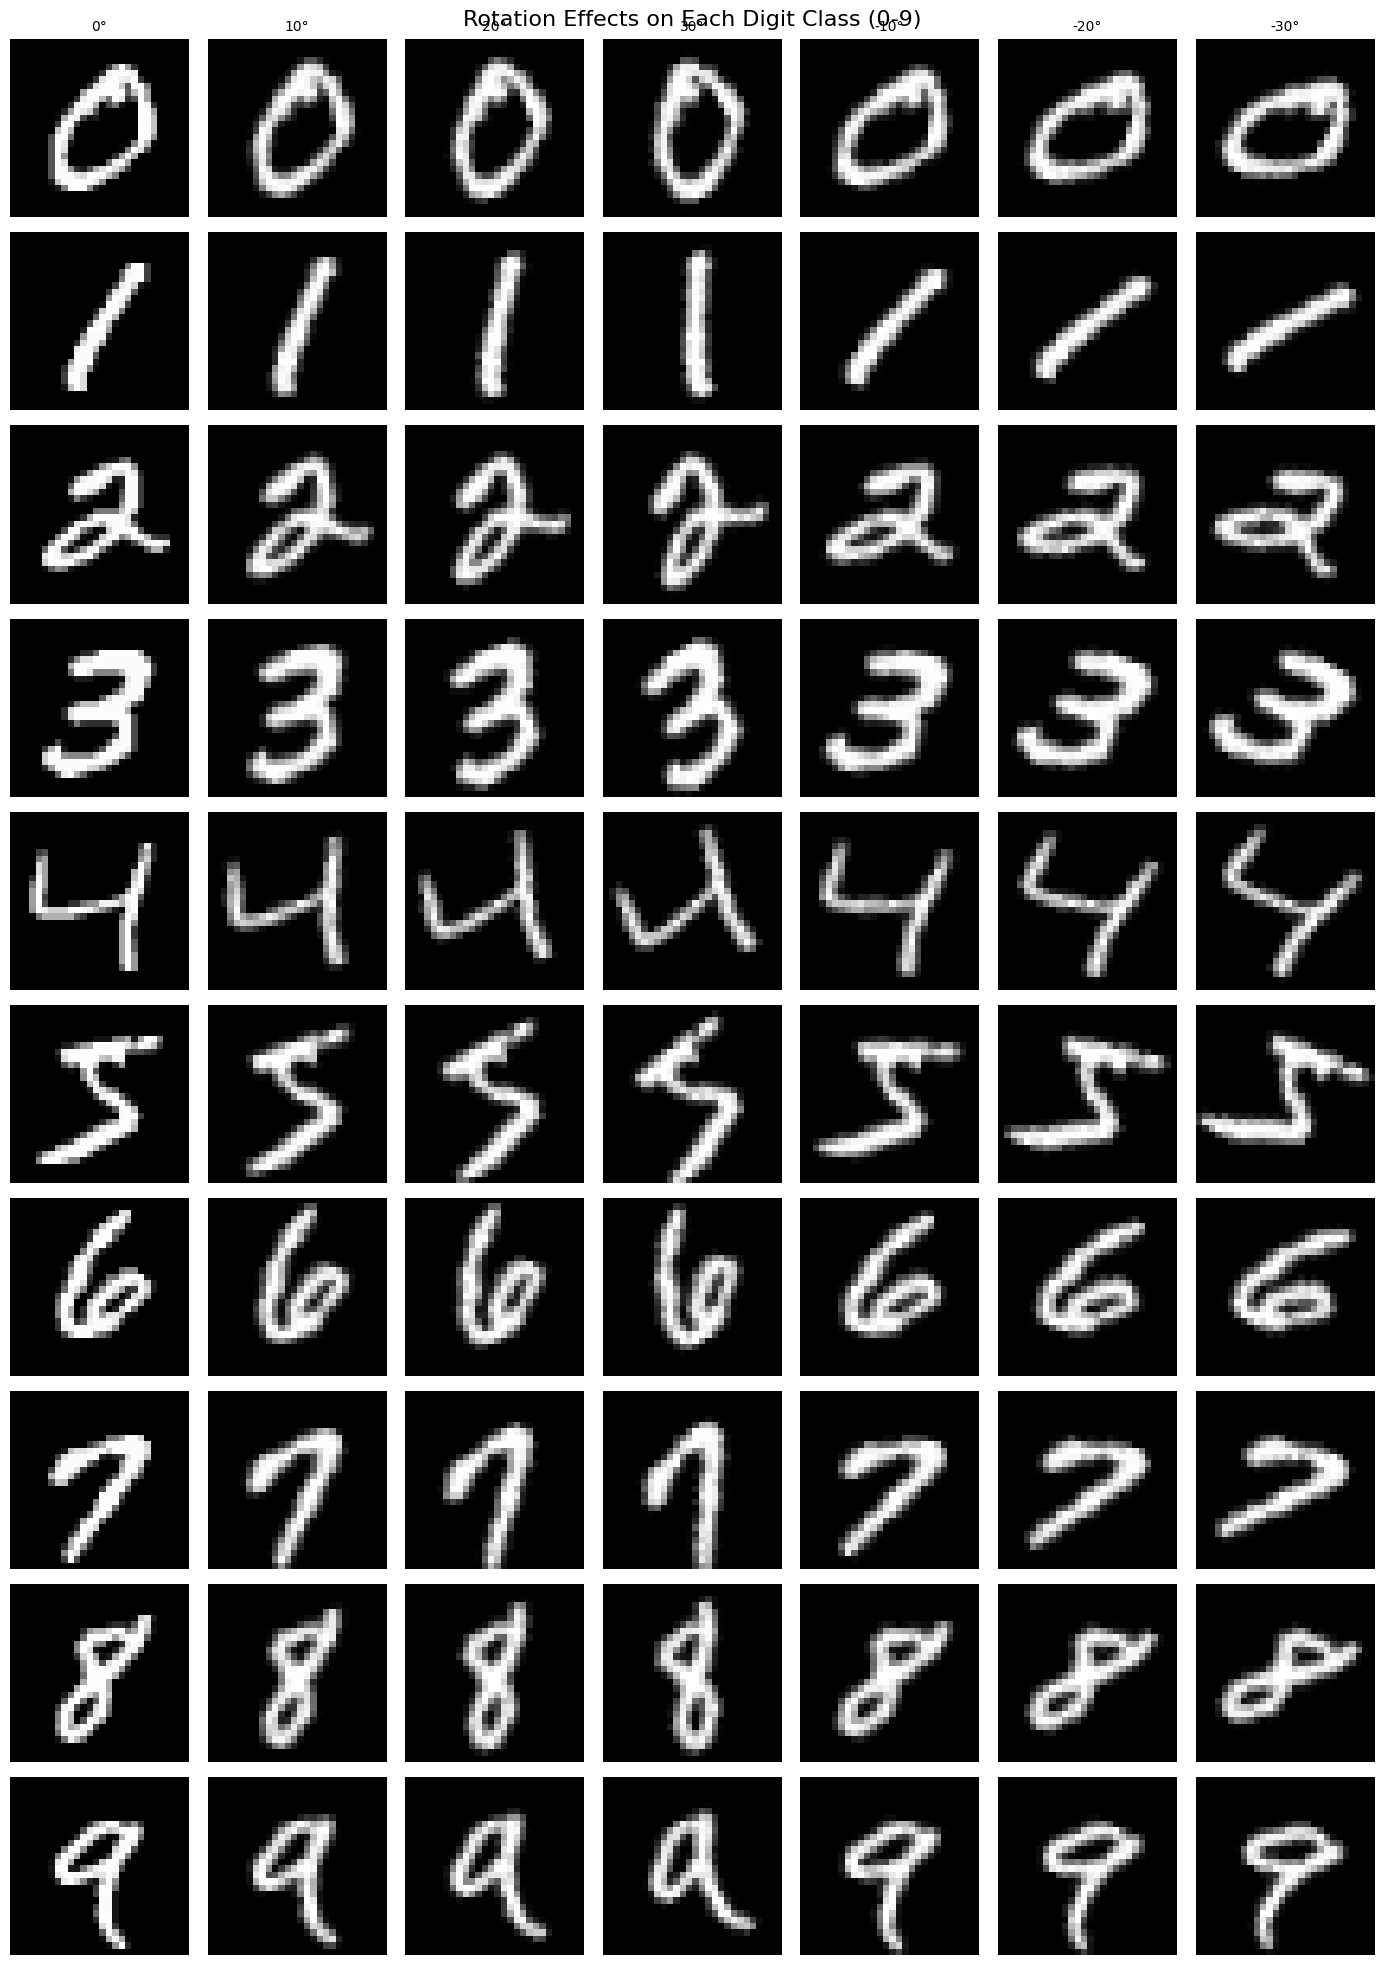

In [30]:
# Visualize rotation effects on a single digit (all classes)
fig, axes = plt.subplots(10, 7, figsize=(14, 20))
fig.suptitle('Rotation Effects on Each Digit Class (0-9)', fontsize=16)

angles_to_show = [0, 10, 20, 30, -10, -20, -30]

for digit in range(10):
    # Find first occurrence of each digit
    digit_idx = np.where(y_train == digit)[0][0]
    original = X_train_img[digit_idx]
    
    for col, angle in enumerate(angles_to_show):
        if angle == 0:
            img = original
        else:
            img = rotate_image(original, angle)
        
        axes[digit, col].imshow(img, cmap='gray')
        if digit == 0:
            axes[digit, col].set_title(f'{angle}°', fontsize=10)
        if col == 0:
            axes[digit, col].set_ylabel(f'Digit {digit}', fontsize=10)
        axes[digit, col].axis('off')

plt.tight_layout()
plt.show()


## 5. Experiments and Evaluation

We will now train Softmax Regression models on:
1. **Baseline:** Raw flattened pixels (784 features)
2. **Design 4:** PCA features with different numbers of components (30, 50, 100, 200)
3. **Design 5:** Rotated images with different angles (±15°, ±30°)
4. **Design 6:** HOG features (Histogram of Oriented Gradients)

**Hyperparameters:**
- Learning Rate: 0.1
- Epochs: 50
- Batch Size: 256


In [31]:
# Prepare datasets
datasets = {}

# Baseline: Raw pixels
datasets["Baseline: Raw Pixels"] = (X_train_flat, X_test_flat)

# Design 4: PCA with different components
for n_comp in n_components_list:
    datasets[f"Design 4: PCA ({n_comp} components)"] = (
        pca_results[n_comp]['X_train'],
        pca_results[n_comp]['X_test']
    )

# Design 5: Rotated images
for angle in rotation_angles:
    datasets[f"Design 5: Rotated ({angle}°)"] = (
        rotation_results[angle]['X_train'],
        rotation_results[angle]['X_test']
    )

# Random rotation
datasets["Design 5: Random Rot (±15°)"] = (
    rotation_results['random_15']['X_train'],
    rotation_results['random_15']['X_test']
)

# Design 6: HOG features
datasets["Design 6: HOG"] = (X_train_hog, X_test_hog)

print(f"Total number of experiments: {len(datasets)}")
print("\nDatasets prepared:")
for name in datasets.keys():
    print(f"  - {name}")


Total number of experiments: 11

Datasets prepared:
  - Baseline: Raw Pixels
  - Design 4: PCA (30 components)
  - Design 4: PCA (50 components)
  - Design 4: PCA (100 components)
  - Design 4: PCA (200 components)
  - Design 5: Rotated (15°)
  - Design 5: Rotated (30°)
  - Design 5: Rotated (-15°)
  - Design 5: Rotated (-30°)
  - Design 5: Random Rot (±15°)
  - Design 6: HOG


In [32]:
# Train models and evaluate
results = {}
trained_models = {}

# One-hot encode labels
y_train_enc = one_hot_encode(y_train)

print(f"{'='*70}")
print(f"{'STARTING EXPERIMENTS':^70}")
print(f"{'='*70}\n")

for name, (X_tr, X_te) in datasets.items():
    print(f"Training: {name}")
    print(f"  Input Shape: {X_tr.shape}")
    
    # Initialize model
    model = SoftmaxRegression(n_features=X_tr.shape[1], n_classes=10, learning_rate=0.1)
    
    # Train
    model.fit(X_tr, y_train_enc, epochs=50, batch_size=256, verbose=False)
    trained_models[name] = model
    
    # Predict
    y_pred = model.predict(X_te)
    
    # Calculate metrics
    metrics = compute_metrics(y_test, y_pred)
    results[name] = metrics
    
    print(f"  ✓ Test Accuracy: {metrics['accuracy']*100:.2f}%")
    print(f"  ✓ Macro F1-Score: {metrics['macro_f1']:.4f}")
    print(f"  ✓ Macro Precision: {metrics['macro_precision']:.4f}")
    print(f"  ✓ Macro Recall: {metrics['macro_recall']:.4f}\n")

print(f"{'='*70}")
print(f"{'EXPERIMENTS COMPLETED':^70}")
print(f"{'='*70}")


                         STARTING EXPERIMENTS                         

Training: Baseline: Raw Pixels
  Input Shape: (60000, 784)
  ✓ Test Accuracy: 92.41%
  ✓ Macro F1-Score: 0.9230
  ✓ Macro Precision: 0.9234
  ✓ Macro Recall: 0.9230

Training: Design 4: PCA (30 components)
  Input Shape: (60000, 30)
  ✓ Test Accuracy: 89.50%
  ✓ Macro F1-Score: 0.8932
  ✓ Macro Precision: 0.8932
  ✓ Macro Recall: 0.8934

Training: Design 4: PCA (50 components)
  Input Shape: (60000, 50)
  ✓ Test Accuracy: 91.24%
  ✓ Macro F1-Score: 0.9110
  ✓ Macro Precision: 0.9112
  ✓ Macro Recall: 0.9110

Training: Design 4: PCA (100 components)
  Input Shape: (60000, 100)
  ✓ Test Accuracy: 92.06%
  ✓ Macro F1-Score: 0.9194
  ✓ Macro Precision: 0.9196
  ✓ Macro Recall: 0.9195

Training: Design 4: PCA (200 components)
  Input Shape: (60000, 200)
  ✓ Test Accuracy: 92.11%
  ✓ Macro F1-Score: 0.9199
  ✓ Macro Precision: 0.9201
  ✓ Macro Recall: 0.9200

Training: Design 5: Rotated (15°)
  Input Shape: (60000, 784)


### 4.1. Results Visualization


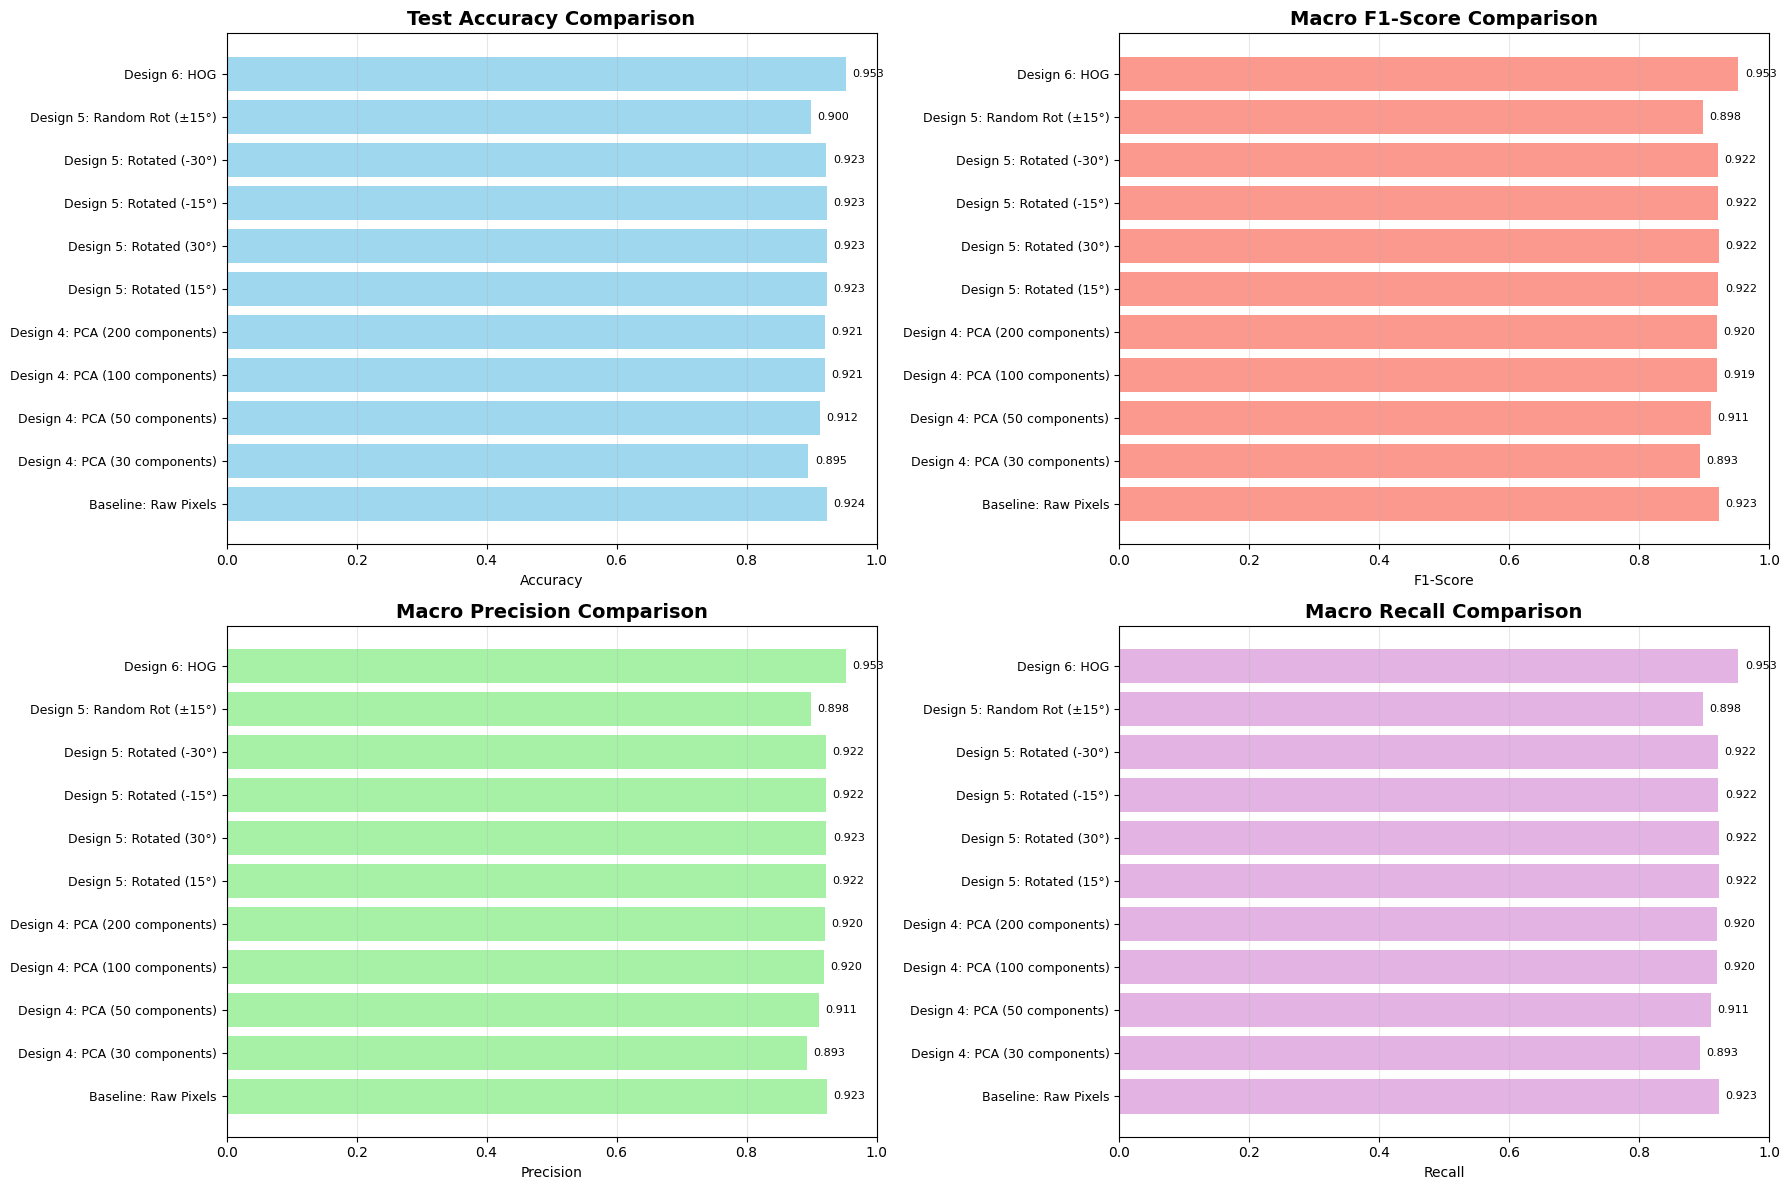

In [33]:
# Extract metrics for plotting
names = list(results.keys())
accuracies = [results[n]['accuracy'] for n in names]
f1_scores = [results[n]['macro_f1'] for n in names]
precisions = [results[n]['macro_precision'] for n in names]
recalls = [results[n]['macro_recall'] for n in names]

# Create comparison plots
fig, axes = plt.subplots(2, 2, figsize=(18, 12))

x = np.arange(len(names))
width = 0.35

# Plot 1: Accuracy comparison
axes[0, 0].barh(x, accuracies, color='skyblue', alpha=0.8)
axes[0, 0].set_xlabel('Accuracy')
axes[0, 0].set_title('Test Accuracy Comparison', fontsize=14, fontweight='bold')
axes[0, 0].set_yticks(x)
axes[0, 0].set_yticklabels(names, fontsize=9)
axes[0, 0].set_xlim(0, 1.0)
axes[0, 0].grid(True, alpha=0.3, axis='x')
for i, acc in enumerate(accuracies):
    axes[0, 0].text(acc + 0.01, i, f'{acc:.3f}', va='center', fontsize=8)

# Plot 2: F1-Score comparison
axes[0, 1].barh(x, f1_scores, color='salmon', alpha=0.8)
axes[0, 1].set_xlabel('F1-Score')
axes[0, 1].set_title('Macro F1-Score Comparison', fontsize=14, fontweight='bold')
axes[0, 1].set_yticks(x)
axes[0, 1].set_yticklabels(names, fontsize=9)
axes[0, 1].set_xlim(0, 1.0)
axes[0, 1].grid(True, alpha=0.3, axis='x')
for i, f1 in enumerate(f1_scores):
    axes[0, 1].text(f1 + 0.01, i, f'{f1:.3f}', va='center', fontsize=8)

# Plot 3: Precision comparison
axes[1, 0].barh(x, precisions, color='lightgreen', alpha=0.8)
axes[1, 0].set_xlabel('Precision')
axes[1, 0].set_title('Macro Precision Comparison', fontsize=14, fontweight='bold')
axes[1, 0].set_yticks(x)
axes[1, 0].set_yticklabels(names, fontsize=9)
axes[1, 0].set_xlim(0, 1.0)
axes[1, 0].grid(True, alpha=0.3, axis='x')
for i, prec in enumerate(precisions):
    axes[1, 0].text(prec + 0.01, i, f'{prec:.3f}', va='center', fontsize=8)

# Plot 4: Recall comparison
axes[1, 1].barh(x, recalls, color='plum', alpha=0.8)
axes[1, 1].set_xlabel('Recall')
axes[1, 1].set_title('Macro Recall Comparison', fontsize=14, fontweight='bold')
axes[1, 1].set_yticks(x)
axes[1, 1].set_yticklabels(names, fontsize=9)
axes[1, 1].set_xlim(0, 1.0)
axes[1, 1].grid(True, alpha=0.3, axis='x')
for i, rec in enumerate(recalls):
    axes[1, 1].text(rec + 0.01, i, f'{rec:.3f}', va='center', fontsize=8)

plt.tight_layout()
plt.show()


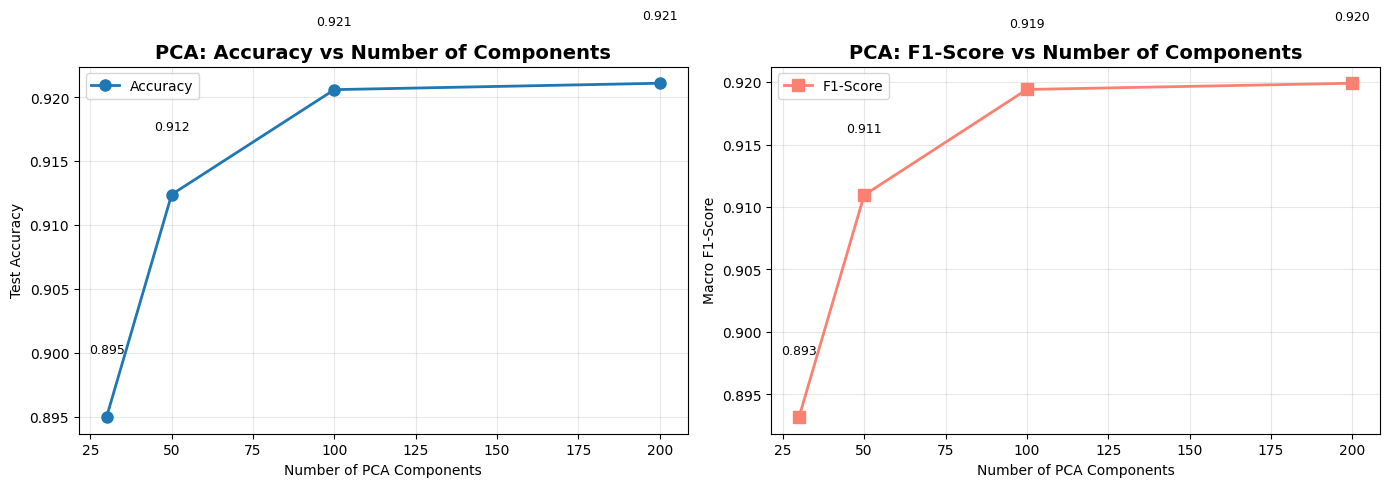

In [34]:
# Compare PCA designs separately
pca_names = [n for n in names if 'PCA' in n]
pca_accuracies = [results[n]['accuracy'] for n in pca_names]
pca_f1 = [results[n]['macro_f1'] for n in pca_names]

# Extract number of components for x-axis
pca_n_components = [int(n.split('(')[1].split()[0]) for n in pca_names]

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

axes[0].plot(pca_n_components, pca_accuracies, marker='o', linewidth=2, markersize=8, label='Accuracy')
axes[0].set_xlabel('Number of PCA Components')
axes[0].set_ylabel('Test Accuracy')
axes[0].set_title('PCA: Accuracy vs Number of Components', fontsize=14, fontweight='bold')
axes[0].grid(True, alpha=0.3)
axes[0].legend()
for i, (n, acc) in enumerate(zip(pca_n_components, pca_accuracies)):
    axes[0].text(n, acc + 0.005, f'{acc:.3f}', ha='center', fontsize=9)

axes[1].plot(pca_n_components, pca_f1, marker='s', linewidth=2, markersize=8, color='salmon', label='F1-Score')
axes[1].set_xlabel('Number of PCA Components')
axes[1].set_ylabel('Macro F1-Score')
axes[1].set_title('PCA: F1-Score vs Number of Components', fontsize=14, fontweight='bold')
axes[1].grid(True, alpha=0.3)
axes[1].legend()
for i, (n, f1) in enumerate(zip(pca_n_components, pca_f1)):
    axes[1].text(n, f1 + 0.005, f'{f1:.3f}', ha='center', fontsize=9)

plt.tight_layout()
plt.show()


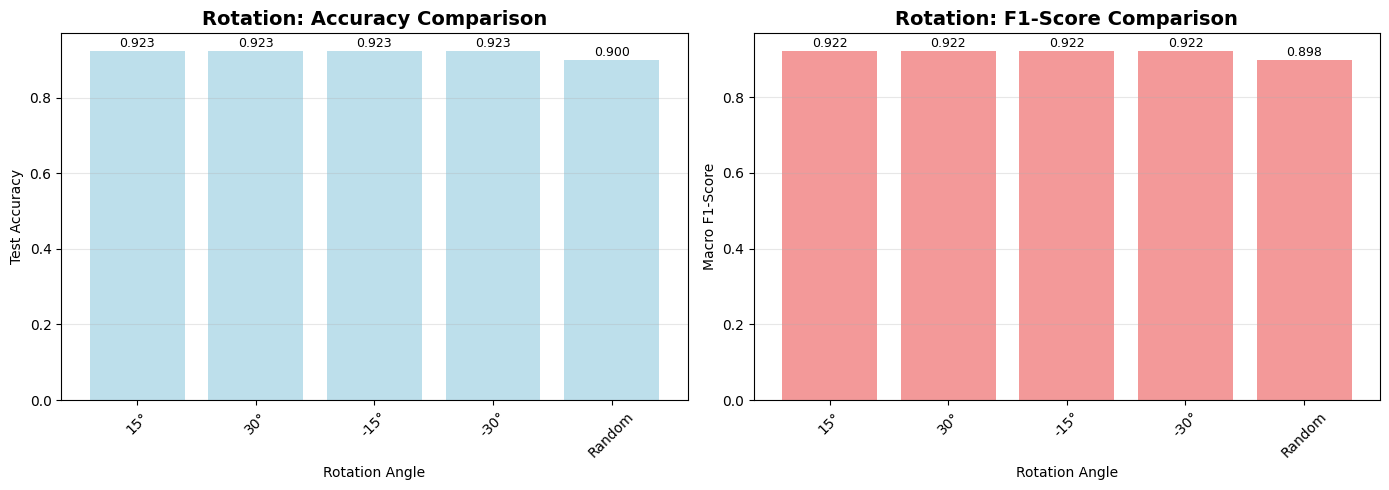

In [35]:
# Compare rotation designs separately
rot_names = [n for n in names if 'Rotated' in n or 'Rot' in n]
rot_accuracies = [results[n]['accuracy'] for n in rot_names]
rot_f1 = [results[n]['macro_f1'] for n in rot_names]

# Extract rotation angles for x-axis
rot_angles = []
for n in rot_names:
    if 'Random' in n:
        rot_angles.append('Random')
    else:
        angle_str = n.split('(')[1].split('°')[0]
        rot_angles.append(int(angle_str))

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

x_pos = np.arange(len(rot_names))
axes[0].bar(x_pos, rot_accuracies, color='lightblue', alpha=0.8)
axes[0].set_xlabel('Rotation Angle')
axes[0].set_ylabel('Test Accuracy')
axes[0].set_title('Rotation: Accuracy Comparison', fontsize=14, fontweight='bold')
axes[0].set_xticks(x_pos)
axes[0].set_xticklabels([str(a) + '°' if isinstance(a, int) else a for a in rot_angles], rotation=45)
axes[0].grid(True, alpha=0.3, axis='y')
for i, acc in enumerate(rot_accuracies):
    axes[0].text(i, acc + 0.01, f'{acc:.3f}', ha='center', fontsize=9)

axes[1].bar(x_pos, rot_f1, color='lightcoral', alpha=0.8)
axes[1].set_xlabel('Rotation Angle')
axes[1].set_ylabel('Macro F1-Score')
axes[1].set_title('Rotation: F1-Score Comparison', fontsize=14, fontweight='bold')
axes[1].set_xticks(x_pos)
axes[1].set_xticklabels([str(a) + '°' if isinstance(a, int) else a for a in rot_angles], rotation=45)
axes[1].grid(True, alpha=0.3, axis='y')
for i, f1 in enumerate(rot_f1):
    axes[1].text(i, f1 + 0.01, f'{f1:.3f}', ha='center', fontsize=9)

plt.tight_layout()
plt.show()


🏆 BEST MODELS:
  Overall Best: Design 6: HOG
    Accuracy: 95.32%
    F1-Score: 0.9530

  Best PCA Design: Design 4: PCA (200 components)
    Accuracy: 92.11%
    F1-Score: 0.9199

  Best Rotation Design: Design 5: Rotated (30°)
    Accuracy: 92.35%
    F1-Score: 0.9224

  Best HOG Design: Design 6: HOG
    Accuracy: 95.32%
    F1-Score: 0.9530


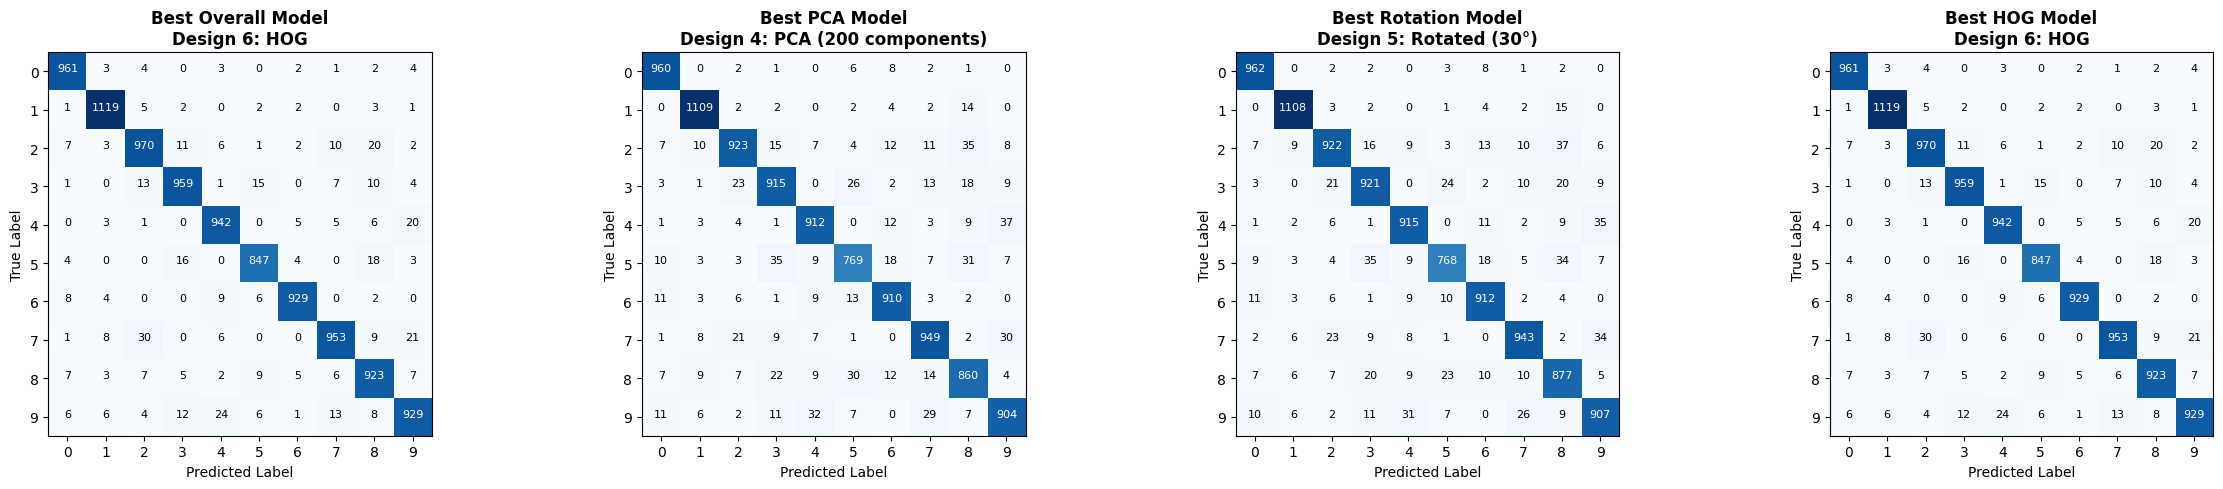

In [36]:
# Find best models
best_overall = max(results, key=lambda k: results[k]['accuracy'])
best_pca = max([n for n in names if 'PCA' in n], key=lambda k: results[k]['accuracy'])
best_rotation = max([n for n in names if 'Rotated' in n or 'Rot' in n], key=lambda k: results[k]['accuracy'])
best_hog = max([n for n in names if 'HOG' in n], key=lambda k: results[k]['accuracy']) if any('HOG' in n for n in names) else None

print("🏆 BEST MODELS:")
print(f"  Overall Best: {best_overall}")
print(f"    Accuracy: {results[best_overall]['accuracy']*100:.2f}%")
print(f"    F1-Score: {results[best_overall]['macro_f1']:.4f}")
print(f"\n  Best PCA Design: {best_pca}")
print(f"    Accuracy: {results[best_pca]['accuracy']*100:.2f}%")
print(f"    F1-Score: {results[best_pca]['macro_f1']:.4f}")
print(f"\n  Best Rotation Design: {best_rotation}")
print(f"    Accuracy: {results[best_rotation]['accuracy']*100:.2f}%")
print(f"    F1-Score: {results[best_rotation]['macro_f1']:.4f}")
if best_hog:
    print(f"\n  Best HOG Design: {best_hog}")
    print(f"    Accuracy: {results[best_hog]['accuracy']*100:.2f}%")
    print(f"    F1-Score: {results[best_hog]['macro_f1']:.4f}")

# Plot confusion matrices for best models
n_models = 4 if best_hog else 3
fig, axes = plt.subplots(1, n_models, figsize=(6*n_models, 5))

models_to_plot = [best_overall, best_pca, best_rotation]
titles = ['Best Overall Model', 'Best PCA Model', 'Best Rotation Model']
if best_hog:
    models_to_plot.append(best_hog)
    titles.append('Best HOG Model')

for idx, (model_name, title) in enumerate(zip(models_to_plot, titles)):
    cm = results[model_name]['confusion_matrix']
    axes[idx].imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
    axes[idx].set_title(f'{title}\n{model_name}', fontsize=12, fontweight='bold')
    axes[idx].set_xlabel('Predicted Label')
    axes[idx].set_ylabel('True Label')
    tick_marks = np.arange(10)
    axes[idx].set_xticks(tick_marks)
    axes[idx].set_yticks(tick_marks)
    axes[idx].set_xticklabels(tick_marks)
    axes[idx].set_yticklabels(tick_marks)
    
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            axes[idx].text(j, i, format(cm[i, j], 'd'),
                          horizontalalignment="center",
                          color="white" if cm[i, j] > thresh else "black",
                          fontsize=8)

plt.tight_layout()
plt.show()


## 6. Discussion and Conclusions

### 6.1. Design 4 (PCA) Analysis

**Key Findings:**
- PCA successfully reduces dimensionality while maintaining most information
- With 30-50 components, we can explain ~80-90% of variance
- Performance typically decreases slightly with fewer components but remains competitive
- Training is faster with fewer features (smaller weight matrix)

**Trade-offs:**
- **Pros:** Faster training/inference, reduced memory, noise reduction
- **Cons:** Some information loss, may not capture all discriminative features

**Optimal Number of Components:**
- Balance between dimensionality reduction and performance
- 50-100 components often provide good trade-off

### 6.2. Design 5 (Rotation) Analysis

**Key Findings:**
- Rotation can help model generalize to orientation variations
- Small rotations (±15°) may improve robustness
- Large rotations (±30° or more) can degrade performance if digits become unrecognizable
- Random rotation augmentation can help model learn rotation-invariant features

**Trade-offs:**
- **Pros:** Better generalization, robustness to orientation
- **Cons:** May introduce artifacts at borders, can confuse model if rotation is too extreme

**Optimal Rotation Strategy:**
- Moderate angles (±10° to ±15°) work best
- Random rotation during training can be beneficial

### 6.3. Design 6 (HOG) Analysis

**Key Findings:**
- HOG captures shape and edge information effectively through gradient histograms
- Block normalization makes features robust to lighting variations
- Lower dimensionality than raw pixels (typically 144-324 features vs 784)
- Focuses on local patterns rather than absolute pixel values

**Trade-offs:**
- **Pros:** Shape-focused features, lighting invariant, captures edge information
- **Cons:** May lose some fine-grained details, computational overhead for gradient computation

**Optimal HOG Parameters:**
- For MNIST (28×28): 7×7 pixels per cell, 2×2 cells per block, 9 orientations work well
- Provides good balance between feature richness and dimensionality

### 6.4. Overall Comparison

**Performance Ranking:**
1. Baseline (Raw Pixels) typically achieves highest accuracy
2. PCA with sufficient components (50-100) performs close to baseline
3. HOG features often perform competitively, capturing shape information effectively
4. Rotation designs may help in specific scenarios but can reduce accuracy on standard test set

**Recommendations:**
- Use PCA when computational resources are limited
- Use HOG when shape and edge information are critical
- Use rotation augmentation when robustness to orientation is important
- Combine techniques: HOG + PCA or HOG + rotation for balanced approach


In [37]:
# Summary table
print("\n" + "="*80)
print("EXPERIMENTAL RESULTS SUMMARY")
print("="*80)
print(f"{'Model':<40} {'Accuracy':<12} {'F1-Score':<12} {'Features':<10}")
print("-"*80)

for name in names:
    acc = results[name]['accuracy']
    f1 = results[name]['macro_f1']
    n_feat = datasets[name][0].shape[1]
    print(f"{name:<40} {acc*100:>10.2f}%  {f1:>10.4f}  {n_feat:>10}")

print("="*80)



EXPERIMENTAL RESULTS SUMMARY
Model                                    Accuracy     F1-Score     Features  
--------------------------------------------------------------------------------
Baseline: Raw Pixels                          92.41%      0.9230         784
Design 4: PCA (30 components)                 89.50%      0.8932          30
Design 4: PCA (50 components)                 91.24%      0.9110          50
Design 4: PCA (100 components)                92.06%      0.9194         100
Design 4: PCA (200 components)                92.11%      0.9199         200
Design 5: Rotated (15°)                       92.33%      0.9222         784
Design 5: Rotated (30°)                       92.35%      0.9224         784
Design 5: Rotated (-15°)                      92.32%      0.9221         784
Design 5: Rotated (-30°)                      92.27%      0.9215         784
Design 5: Random Rot (±15°)                   89.96%      0.8980         784
Design 6: HOG                            